## Finalizing thesis diagrams

This notebook will finalize diagrams for the thesis to insure that all use the same grouping of elements. This will slice the dataframe by one year and add the diagrams.

In [1]:
# Do not modify import block, all necessary imports are included
# Our regular libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
%matplotlib inline

# This is for our hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

# For our k-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn import datasets
import random

# for plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# this is for density plotting
from matplotlib import colorbar, colors
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# import gsw
import math

# for the polygon intersections
import shapely.geometry as sg

# for plotting
import time
import warnings
warnings.filterwarnings('ignore')

#import "/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/gsw"
import sys
 
# appending a path
# sys.path.append('/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/')
 
# importing required module
import gsw

from scipy.interpolate import interpn

### Slice the points by one year, load the release points, load the dataframe for KMeans

In [2]:
# load the libraries
ds = "/scratch/mmurakami/WAOM/drifter_data_all_withdepth.nc"
ds = xr.load_dataset(ds)

In [3]:
y4_5 = 140160 # 140160 = 35040 * 4 = 4 years
y3_5 = int(35040*3+35040*1)

wmt = xr.load_dataset("/scratch/mmurakami/WAOM/categorized.nc")
# wmt = wmt.where(~np.isnan(ds.Xgrid))
wmt = wmt.categorized.values[:y3_5]


### Make the grids of salt temp and dens

In [4]:
# arr = wmt[-1]
# unique_values, counts = np.unique(arr, return_counts=True)
# names = ['AABW', 'MCDW', 'ISW', 'DSW', 'AASW', 'WW', 'mSW','beached']
# beached = 0
# for i,j in zip(unique_values,counts):
#     if np.isnan(i):
#         beached += 1
#     else:
#         print(names[int(i)],j,(j/3895))
# print("beached",beached,beached/3895)

In [5]:
# select the initial columns of values (at all times)


salt = ds.variables['salt'].values[:y3_5]
temp = ds.variables['temp'].values[:y3_5]
dens = ds.variables['rho'].values[:y3_5]
depth = ds.variables['depth'].values[:y3_5]

In [6]:
idxs = np.where(~np.isnan(salt[-1]))

In [8]:
idxs[0].shape


idxs = idxs[0]
path = "/scratch/mmurakami/WAOM/groups/"
idxs.tofile(path + "idxs.txt",sep=",")

In [85]:
salt = salt[:,idxs[0]]
temp = temp[:,idxs[0]]
dens = dens[:,idxs[0]]
wmt = wmt[:,idxs[0]]

### CT and SA

In [86]:
# # convert the waom values to gsw values
# # convert depth to sea pressure
# long = 73.5089
# lat = -66.8245
# p = gsw.p_from_z(z=depth,lat=-66.8245)


# # convert the absolute salinity from practical salinity
# SA = gsw.SA_from_SP(salt,p,long,lat)    # absolute salinity from practical salinity

# # convert potential T to conservative T
# CT = gsw.CT_from_pt(SA,temp)   # conservative T from potential T

# # find the potential density from SA, CT, p
# # rho_pot0 = gsw.rho(SA,CT,0) - 1000
# rho_pot = gsw.rho(SA,CT,p) - 1000

## Now create the grouping

In [87]:
# convert the absolute salinity from practical salinity
# dSA = SA[-1]-SA[0]
dSA = salt[-1]-salt[0]
dCT = temp[-1]-temp[0]
drho_pot = dens[-1]-dens[0]


df = pd.DataFrame()
df["dT"] = dCT
df["dsat"] = dSA
df["drho"] = drho_pot
df

,dT,dsat,drho
0,1.003796,0.492970,1.464422
1,0.798771,0.261040,0.565941
2,0.733726,-0.111305,1.075357
3,1.352079,0.226284,1.229233
4,1.044552,0.098019,1.613560
...,...,...,...
3028,-2.310728,0.713142,11.429031
3029,-2.127896,0.349644,2.502554
3030,0.097079,-0.200241,-0.020504
3031,-0.090273,-0.107098,0.909195


[2507 1930  940 2744]
whats up
Cluster 0:
114
Cluster 1:
2001
Cluster 2:
388
Cluster 3:
530


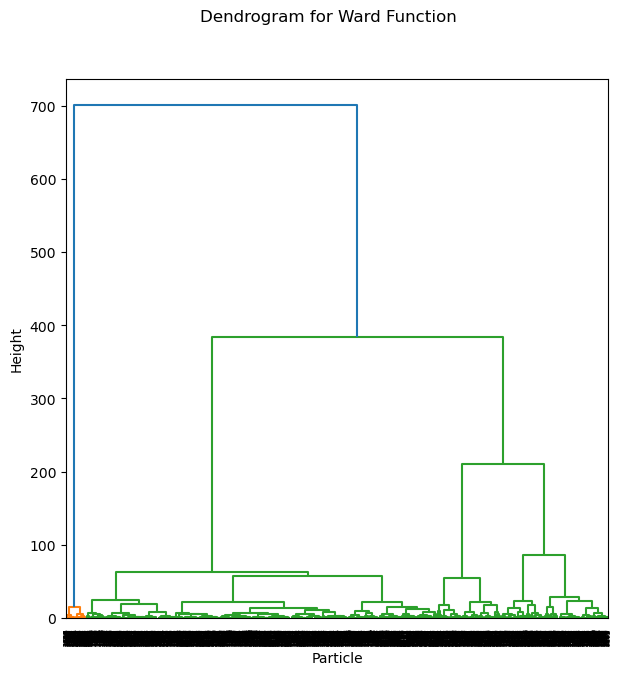

In [88]:
# Plot the dendrogram for the Ward proximity measure
index_names = list(df.index)
z = linkage(df,method='ward')
plt.figure(figsize = (7,7))
plt.suptitle('Dendrogram for Ward Function')
plt.xlabel('Particle')
plt.ylabel('Height')
dendrogramward = dendrogram(Z=z,labels=index_names,get_leaves=True)

# set the number of clusters and get the names
numclust = 4  # this was 6
fl = fcluster(z,numclust,criterion='maxclust')
# new dataframe
df_clst = pd.DataFrame()
df_clst['index']  = index_names
df_clst['clust_label']  = fl
# get the clusters from fcluster to choose centroids
centroids_idx = np.array([],dtype=int)
# for i in range(6):
for i in range(4):
    # print the values in each group
    elements = df_clst[df_clst['clust_label']==i+1]['index'].tolist()  
    size = len(elements)    
    # get a random number from elements as a centroid
    centroids_idx = np.append(centroids_idx, random.choice(elements))
print(centroids_idx)

# get the initial centroids
index_names = list(df.index)
c0 = df.iloc[index_names.index(centroids_idx[0])]
c1 = df.iloc[index_names.index(centroids_idx[1])]
c2 = df.iloc[index_names.index(centroids_idx[2])]
c3 = df.iloc[index_names.index(centroids_idx[3])]
# c4 = df.iloc[index_names.index(centroids_idx[4])]
# c5 = df.iloc[index_names.index(centroids_idx[5])]

centroids = np.array([c0,c1,c2,c3]) #,c4,c5])

# Compute the k-means clusters and show the listing of the States in each cluster
kmeans = KMeans(n_clusters=4,init=centroids,n_init=1,random_state=23).fit(df)
centroids = kmeans.cluster_centers_
assignment = kmeans.fit_predict(df,centroids)

# get the cluster for each state
zeroes=[x for x,y in enumerate(assignment) if y == 0]
ones=[x for x,y in enumerate(assignment) if y == 1]
twos=[x for x,y in enumerate(assignment) if y == 2]
threes=[x for x,y in enumerate(assignment) if y == 3]
# fours=[x for x,y in enumerate(assignment) if y == 4]
# fives=[x for x,y in enumerate(assignment) if y == 5]

clusters = [zeroes,ones,twos,threes]  #,fours,fives]
states = [[],[],[],[]] #,[],[]]
num = 0
print("whats up")
for clust in clusters:
    for idx in clust:
        state = index_names[idx]
        states[num].append(state)
    print('Cluster '+str(num)+':')
    print(len(states[num]))
    num += 1

In [89]:
len(states)

4

In [90]:
# # get the indices for each of the groups
group1 = states[0]
group2 = states[1]
group3 = states[2]
group4 = states[3]
# group5 = states[4]
# group6 = states[5]
groups = np.array([group1,group2,group3,group4],dtype=object)   #,group5,group6

### Check the quality of the grouping

In [91]:
wmt_1 = wmt[-1]

In [97]:
# quality of the grouping
# find the number of values in each group that match each of the water masses
# we have the arrays temp, freez_temp, salt, enddens_allvals, depth
lengths = np.array([])
AABW_percents = np.array([])
MCDW_percents = np.array([])
ISW_percents = np.array([])
DSW_percents = np.array([])
AASW_percents = np.array([])
WW_percents = np.array([])
other_percents = np.array([])

for group in groups:
    # how many particles are in the group
    lengths = np.append(lengths,len(group))
    
    # get the individual quantities of each group from mass and do value counts
    thismass = wmt_1[group]  # or wmt_1
    # thismass = wmt[0][group]
    unique_elements, counts_elements = np.unique(thismass, return_counts=True)
    
    # see if any number is not in list and if not then add 0 to the end of the list
    for i in range(7):
        if not np.any(unique_elements == i):
            # append this number and zero to unique,counts
            unique_elements = np.append(unique_elements,i)
            counts_elements = np.append(counts_elements,0)
            
    # 0 is aabw, 1 is mcdw, 2 is isw, 3 is dsw, 4 is aasw, 5 is other (ISW shallower than 100m), 6 is msw
    
    for i in range(len(unique_elements)):
        if unique_elements[i] == 0:
            AABW_percents =np.append(AABW_percents,counts_elements[i])
        elif unique_elements[i] == 1:
            MCDW_percents =np.append(MCDW_percents,counts_elements[i])
        elif unique_elements[i] == 2:
            ISW_percents =np.append(ISW_percents,counts_elements[i])
        elif unique_elements[i] == 3:
            DSW_percents =np.append(DSW_percents,counts_elements[i])
        elif unique_elements[i] == 4:
            AASW_percents =np.append(AASW_percents,counts_elements[i])
        elif unique_elements[i] == 5:
            WW_percents = np.append(WW_percents,counts_elements[i])
        elif unique_elements[i] == 6:
            other_percents = np.append(other_percents,counts_elements[i])

In [98]:
wmt_df = pd.DataFrame() #,"5","6"])
wmt_df["# of particles"] = lengths
wmt_df["AABW"] = AABW_percents
wmt_df["MCDW"] = MCDW_percents
wmt_df["ISW"] = ISW_percents
wmt_df["DSW"] = DSW_percents
wmt_df["AASW"] = AASW_percents
wmt_df["WW"] = WW_percents
wmt_df["mSW"] = other_percents

# rename the indices
# wmt_df = wmt_df.reindex(["1","2","4","2"])

wmt_df

,# of particles,AABW,MCDW,ISW,DSW,AASW,WW,mSW
0,114.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0
1,2001.0,5.0,1055.0,49.0,0.0,800.0,86.0,6.0
2,388.0,388.0,0.0,0.0,0.0,0.0,0.0,0.0
3,530.0,459.0,57.0,14.0,0.0,0.0,0.0,0.0


In [99]:
# 616 DSW should be at start
print(sum(DSW_percents))

0.0


In [100]:
# remake the above dataframe with percentages
df1 = pd.DataFrame()# index=["1","2","3","4"])
df1["% of Total"] = wmt_df["# of particles"]/sum(wmt_df["# of particles"])
df1["AABW"] = wmt_df["AABW"]/wmt_df["# of particles"]
df1["mCDW"] = wmt_df["MCDW"]/wmt_df["# of particles"]
df1["ISW"] = wmt_df["ISW"]/wmt_df["# of particles"]
df1["DSW"] = wmt_df["DSW"]/wmt_df["# of particles"]
df1["AASW"] = wmt_df["AASW"]/wmt_df["# of particles"]
df1["WW"] = wmt_df["WW"]/wmt_df["# of particles"]
df1["mSW"] = wmt_df["mSW"]/wmt_df["# of particles"]

# df1 = df1.reindex(["3","1","6","2","4","5"])

In [101]:
df1.style.format({
    '% of Total': '{:,.2%}'.format,
    'AABW': '{:,.2%}'.format,
    'mCDW': '{:,.2%}'.format,
    'ISW' : '{:,.2%}'.format,
    'DSW' : '{:,.2%}'.format,
    'AASW': '{:,.2%}'.format,
    'WW'  : '{:,.2%}'.format,
    'mSW' : '{:,.2%}'.format
})

,% of Total,AABW,mCDW,ISW,DSW,AASW,WW,mSW
0,3.76%,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%
1,65.97%,0.25%,52.72%,2.45%,0.00%,39.98%,4.30%,0.30%
2,12.79%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
3,17.47%,86.60%,10.75%,2.64%,0.00%,0.00%,0.00%,0.00%


In [102]:
path = "/scratch/mmurakami/WAOM/groups/"

In [104]:
group3a = np.asarray(group1)
group3a.tofile(path + "group1.txt",sep=",")
#group1 = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/GroupFiles/group1_4grps.txt",sep=",")

group1a = np.asarray(group2)
group1a.tofile(path + "group2.txt",sep=",")
#group2 = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/GroupFiles/group2_4grps.txt",sep=",")

group6a = np.asarray(group3)
group6a.tofile(path + "group3.txt",sep=",")
#group3 = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/GroupFiles/group3_4grps.txt",sep=",")

group2a = np.asarray(group4)
group2a.tofile(path + "group4.txt",sep=",")

#group4 = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/GroupFiles/group4_4grps.txt",sep=",")

In [68]:
# group0 = group0.tolist()
# group0 = [int(x) for x in group0]

group1 = group1.tolist()
group1 = [int(x) for x in group1]

group2 = group2.tolist()
group2 = [int(x) for x in group2]

group3 = group3.tolist()
group3 = [int(x) for x in group3]

group4 = group4.tolist()
group4 = [int(x) for x in group4]

# group5 = group5.tolist()
# group5 = [int(x) for x in group5]

In [69]:
groups = np.array([group1,group2,group3,group4],dtype=object)   #,group5,group6